In [6]:
# Import library and set up environment
import os as os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torch.optim as optim
from torchvision import transforms
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_workers = torch.cuda.device_count()
print("Number of GPU workers available:", num_workers)

cuda
Number of GPU workers available: 2


In [8]:
# Create a residual block
class ResidualBlock(nn.Module):
    def __init__(self, channels1,channels2,res_stride=1):
        super(ResidualBlock, self).__init__()
        self.inplanes=channels1
        # First convolution layer in residual block +- downsampling         
        self.conv1 = nn.Conv2d(channels1, channels2, 3, res_stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels2)
        # Second convolution layer in residual block with no downsampling         
        self.conv2 = nn.Conv2d(channels2, channels2, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels2)
        # Create a shortcut layer that will store the original information
        if res_stride != 1 or channels2 != channels1:
            # In case there is downsampling or changes of number of channel
            self.shortcut=nn.Sequential(
                nn.Conv2d(channels1, channels2, 1, res_stride, 0, bias=False),
                nn.BatchNorm2d(channels2)
            )
        else:
            # In case there is NO downsampling or changes of number of channel -> Identical mapping
            self.shortcut=nn.Sequential()
    def forward(self, x):
        # forward pass: Conv2d > BatchNorm2d > ReLU > Conv2D > BatchNorm2d > ADD > ReLU
        out=self.conv1(x)
        out=self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = out + self.shortcut(x)
        # final ReLu
        out = F.relu(out)
        return out

In [9]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_strides, num_features, in_channels, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = num_features[0] # in_planes stores the number channels output from first convolution
        # Initialise the network with a 3 x3 conv and batch norm
        self.conv1 = nn.Conv2d(in_channels, num_features[0], 3, num_strides[0], padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features[0])
        # Create 4 residual layers, each layer have num_blocks of residual block
        self.layer1 = self._make_layer(block, num_features[1], num_blocks, stride=num_strides[1])
        self.layer2 = self._make_layer(block, num_features[2], num_blocks, stride=num_strides[2])
        self.layer3 = self._make_layer(block, num_features[3], num_blocks, stride=num_strides[3])
        self.layer4 = self._make_layer(block, num_features[4], num_blocks, stride=num_strides[4])
        # Last Linear layer to make number of channel equal number of class
        self.linear = nn.Linear(num_features[4],num_classes)
    def _make_layer(self, block, planes, num_blocks, stride):
        # A layer have man
        layers = []
        # First block in the layer is a residual block with downsampling and increase channel dimension
        # It has the number of input channels equal to output channels in previous layer        
        layers.append(block(self.in_planes, planes, stride))
        # The rest blocks are identical residual block 
        for i in np.arange(num_blocks-1):
            layers.append(block(planes, planes))
        # Update input for next residual layer
        self.in_planes = planes
        # Create sequential with many residual blocks
        return nn.Sequential(*layers)

    def forward(self, x):
        # initial convolution and batch norm
        out = F.relu(self.bn1(self.conv1(x)))
        # Residual layers (A total of 4x3 = 12 residual blocks)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # Average pool
        out = F.avg_pool2d(out, 4)
        # Flatten for classification
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [10]:
# Load the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])
training = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(training, batch_size=32, shuffle=True, num_workers=2)
# Create dataloader
testing = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testing, batch_size=32, shuffle=False, num_workers=2)
# Label the classes
classes = ('0', '1', '2', '3',
          '4', '5', '6', '7', '8', '9')

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 35041401.03it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1019360.41it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8720030.91it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3303941.86it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [11]:
# Declare network, loss function, and optimizer
resnet = ResNet(ResidualBlock,3, [1,1,2,2,2], [64,64,128,256,512], in_channels=1)
resnet = resnet.to(device)
loss_fun = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

In [12]:
# Declare number of epoch
num_epochs = 2
# Start training
loss_list = []
for epoch in range(num_epochs):
    resnet.train()
    for i, (data, labels) in enumerate(train_loader, 0):
        # Push data to GPU, clear gradient, calculate loss, backpropagation
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = resnet(data)
        loss = loss_fun(output, labels)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        # print the loss 
        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Data [{i*len(labels)}/{len(train_loader.dataset)}], Loss: {loss.item()}")

Epoch [1/2], Data [0/60000], Loss: 2.5278334617614746
Epoch [1/2], Data [1600/60000], Loss: 0.6387321352958679
Epoch [1/2], Data [3200/60000], Loss: 0.31323838233947754
Epoch [1/2], Data [4800/60000], Loss: 0.3863244950771332
Epoch [1/2], Data [6400/60000], Loss: 0.1180701032280922
Epoch [1/2], Data [8000/60000], Loss: 0.15823322534561157
Epoch [1/2], Data [9600/60000], Loss: 0.06192661076784134
Epoch [1/2], Data [11200/60000], Loss: 0.15203939378261566
Epoch [1/2], Data [12800/60000], Loss: 0.1288701593875885
Epoch [1/2], Data [14400/60000], Loss: 0.034646693617105484
Epoch [1/2], Data [16000/60000], Loss: 0.006278950721025467
Epoch [1/2], Data [17600/60000], Loss: 0.12240207195281982
Epoch [1/2], Data [19200/60000], Loss: 0.09303555637598038
Epoch [1/2], Data [20800/60000], Loss: 0.12796415388584137
Epoch [1/2], Data [22400/60000], Loss: 0.2869918942451477
Epoch [1/2], Data [24000/60000], Loss: 0.09101325273513794
Epoch [1/2], Data [25600/60000], Loss: 0.0629618912935257
Epoch [1/2],

In [13]:
# Declare performance metrics
total_loss = []
accuracy = []
f1 = []
precision = []
recall = []
# Test the model
resnet.eval()
for i, (data, labels) in enumerate(test_loader, 0):
    # Push data to GPU, predict, and calculate the loss 
    data = data.to(device)
    labels = labels.to(device)
    output = resnet(data)
    loss = loss_fun(output, labels)
    # Append the loss
    total_loss.append(loss.item())
    # Make prediction
    _, y_pred = torch.max(output, 1)
    # Calculate performance
    y_true = labels.data.cpu().numpy()
    y_pred = y_pred.data.cpu().numpy()
    accuracy.append(accuracy_score(y_true, y_pred))
    f1.append(f1_score(y_true, y_pred, average='macro'))
    precision.append(precision_score(y_true, y_pred, average='macro', zero_division=1))
    recall.append(recall_score(y_true, y_pred, average='macro', zero_division=1))

# print the loss 
print(f"Loss: {round(np.array(total_loss).mean(),4)}")
print('accuracy:', round(np.array(accuracy).mean(),4), ', f1 score:', round(np.array(f1).mean(),4), ', precision:', round(np.array(precision).mean(),4), ', recall:', round(np.array(recall).mean(),4))    


Loss: 0.0245
accuracy: 0.9913 , f1 score: 0.9889 , precision: 0.9914 , recall: 0.9912


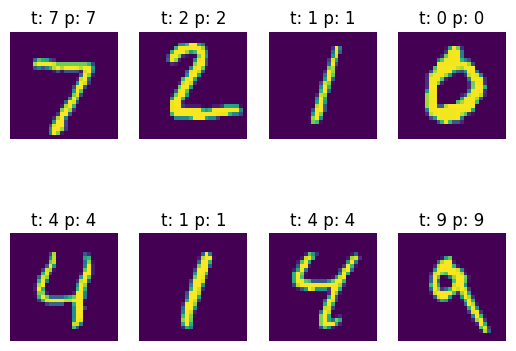

In [14]:
# Make an iterator from test_loader
test_iterator = iter(test_loader)
# Get a batch of testing images
images, labels = next(test_iterator)
# Push to device
images = images.to(device)
labels = labels.to(device)
# Run the model
y_score = resnet(images)
# Get predicted class from the class probabilities
_, y_pred = torch.max(y_score, 1)
# Plot results
rows = 2
columns = 4
# plot y_score - true label (t) vs predicted label (p)
fig = plt.figure()
for i in range(rows*columns):
    fig.add_subplot(rows, columns, i+1)
    plt.title('t: ' + classes[labels[i].cpu()] + ' p: ' + classes[y_pred[i].cpu()])
    img = images[i] / 2 + 0.5     # this is to unnormalize the image
    img = torchvision.transforms.ToPILImage()(img.cpu())
    plt.axis('off')
    plt.imshow(img)
plt.show()
